In [47]:
from util import Config

from model import Model

from simulate import proj, configs, get_save_dir

%load_ext autoreload
%autoreload 2

def save(config):
    (configs / (config.name + '.json')).save(vars(config))
    return config

def load(config_name):
    return Config(**(configs / (config_name + '.json')).load())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
config_8 = Config(proj / 'results_8x8').load()

config_8_0 = save(Config(**vars(config_8)).var(name='8x8_0', epoch=0, eval_mcts_iterations=5000))
config_8_40000 = save(Config(**vars(config_8)).var(name='8x8_40000', epoch=40000, eval_mcts_iterations=5000))
config_8_60000 = save(Config(**vars(config_8)).var(name='8x8_60000', epoch=60000, eval_mcts_iterations=5000))

config_12 = Config(proj / 'results_12x12').load()
config_12_0 = save(Config(**vars(config_12)).var(name='12x12_0', epoch=0, eval_mcts_iterations=15000))
config_12_0_ponly = save(Config(**vars(config_12)).var(name='12x12_0_ponly', epoch=0, eval_mcts_iterations=0))
config_12_8000 = save(Config(**vars(config_12)).var(name='12x12_8000', epoch=8000, eval_mcts_iterations=15000))
config_12_8000_ponly = save(Config(**vars(config_12)).var(name='12x12_8000_ponly', epoch=8000, eval_mcts_iterations=0))

config_20 = Config(proj / 'results_20x20').load()
config_20_0 = save(Config(**vars(config_20)).var(name='20x20_0', epoch=0, eval_mcts_iterations=15000))
config_20_2000 = save(Config(**vars(config_20)).var(name='20x20_2000', epoch=2000, eval_mcts_iterations=15000))
config_20_4000 = save(Config(**vars(config_20)).var(name='20x20_4000', epoch=4000, eval_mcts_iterations=15000))
config_20_7000 = save(Config(**vars(config_20)).var(name='20x20_7000', epoch=7000, eval_mcts_iterations=15000))
config_20_8500 = save(Config(**vars(config_20)).var(name='20x20_8500', epoch=8500, eval_mcts_iterations=15000))

In [260]:
config1 = config_20_4000
config2 = config_20_7000
save_dir = get_save_dir(config1, config2)

for i in range(20):
    game = (save_dir / ('%04d.npy' % i)).load().item()
    config1 = load(game['config1'])
    config2 = load(game['config2'])
    game = game['game']
    num_moves = len(game['move'])
#     print(config1.name, config2.name)
    if num_moves == config1.board_dim ** 2:
        print('draw')
    elif num_moves % 2 == 1:
        print('%s won' % config1.name)
    else:
        print('%s won' % config2.name)

20x20_7000 won
20x20_4000 won
20x20_4000 won
20x20_7000 won
20x20_7000 won
20x20_7000 won
20x20_4000 won
20x20_7000 won
20x20_4000 won
20x20_7000 won
20x20_4000 won
20x20_7000 won
20x20_7000 won
20x20_7000 won
20x20_7000 won
20x20_7000 won
20x20_7000 won
20x20_7000 won
20x20_4000 won
20x20_7000 won


In [287]:
config1 = config_20_4000
config2 = config_20_7000
save_dir = get_save_dir(config1, config2)

game_i = 15

output_dir = (save_dir / ('visuals_%s' % game_i)).mk()

game = (save_dir / ('%04d.npy' % game_i)).load().item()
config1 = load(game['config1'])
config2 = load(game['config2'])
game = game['game']

infos = list(map(game.get, ['state', 'curr_p', 'curr_v', 'curr_W', 'curr_N', 'next_p', 'next_v', 'move', 'time']))

In [288]:
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, FixedLocator, AutoMinorLocator

save_fig = True
fontsize = 18
offset = 0.3

def norm(a):
    return a / a.sum()

def plot_info(t, state, *args):
    terminal = len(args) == 0
    if not terminal:
        curr_p, curr_v, curr_W, curr_N, next_p, next_v, move, time = args
    else:
        time = 0
    
    dim = config1.board_dim
    
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = plt.cm.Reds if t % 2 else plt.cm.Blues
    if terminal:
        merged = np.zeros((dim, 2 * dim))
    else:
        expand = lambda a: np.expand_dims(a, axis=-1)
        merged = np.concatenate([expand(curr_p), expand(norm(curr_N))], axis=-1).reshape(dim, 2 * dim)
    ax.pcolor(merged, cmap=cmap, vmax=1, vmin=0)
    ax.grid(True, which='major', axis='both', linestyle='-', color='k')

    def xtick_formatter(x, pos=None):
        return '%d' % (x // 2)
    
    ax.xaxis.set_major_locator(FixedLocator(2 * np.arange(dim)))
    ax.xaxis.set_major_formatter(FormatStrFormatter(''))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_formatter(FuncFormatter(xtick_formatter))
    for tick in ax.xaxis.get_minor_ticks():
        tick.label.set_fontsize(fontsize)
    
    ax.yaxis.set_major_locator(FixedLocator(np.arange(dim)))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_formatter(FormatStrFormatter(''))
    ax.yaxis.set_minor_formatter(FormatStrFormatter('%d'))
    for tick in ax.yaxis.get_minor_ticks():
        tick.label.set_fontsize(fontsize)
    
    ax.set_xlabel('Compute time: %.1f' % time, fontsize=fontsize)
    ax.set_title('P1: %s (X, Blue)    P2: %s (O, Red)' % (config1.name, config2.name), fontsize=fontsize)
    
    board_state = state[:2]
    for y in range(dim):
        for x in range(dim):
            if state[t % 2, y, x]:
                ax.text(2 * (x + offset), y + offset, 'X', fontsize=fontsize)
            if state[(t + 1) % 2, y, x]:
                ax.text(2 * (x + offset), y + offset, 'O', fontsize=fontsize)
    if save_fig:
        plt.savefig(output_dir / '%03d.jpg' % t)
    plt.show()
    

from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize

def make_video(image_files, fps=2):
    fourcc = VideoWriter_fourcc(*'XVID')
    vid = None
    for file in image_files:
        img = imread(file)
        if vid is None:
            size = img.shape[1], img.shape[0]
            vid = VideoWriter(output_dir / 'video.mp4', fourcc, float(fps), size, True)
        vid.write(img)
    vid.release()

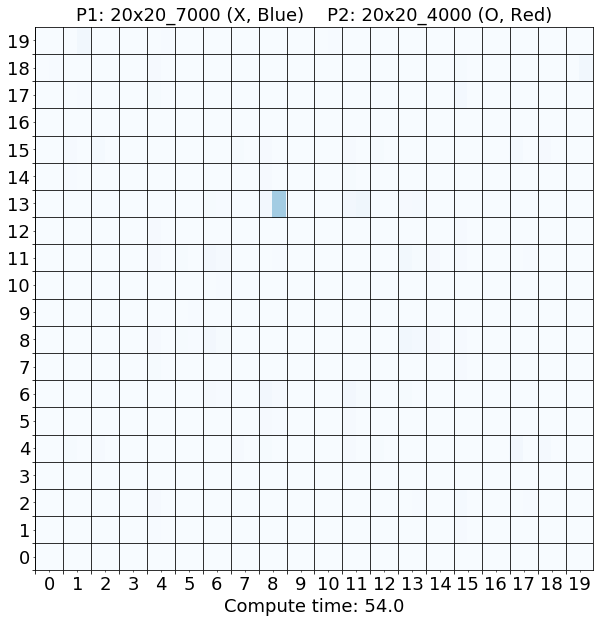

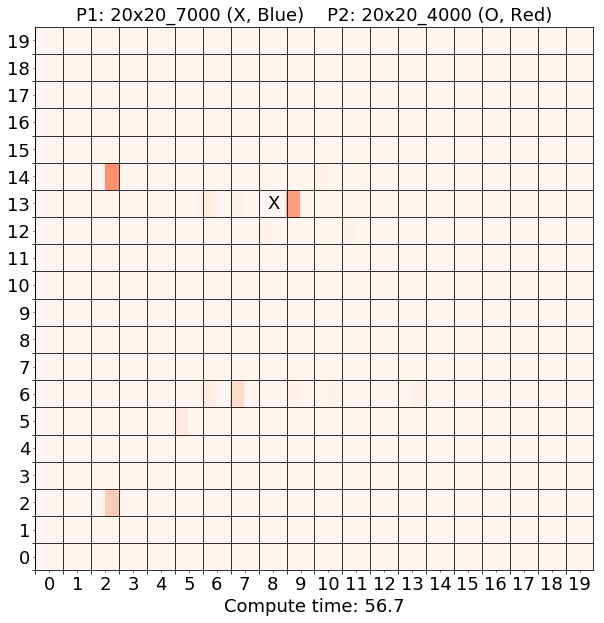

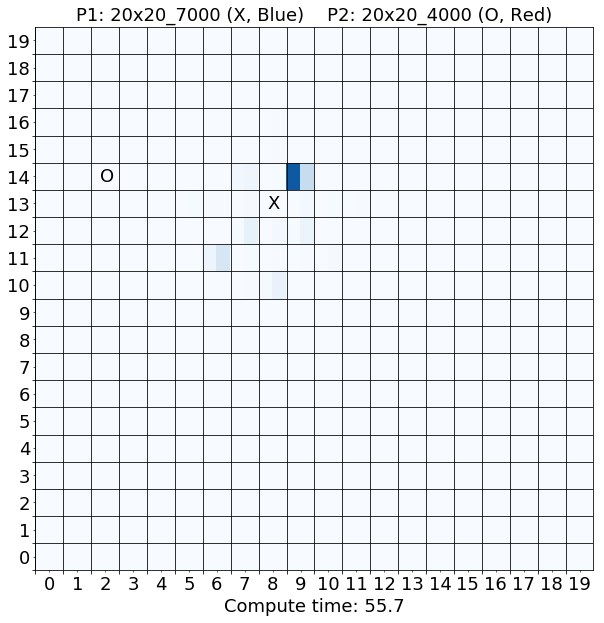

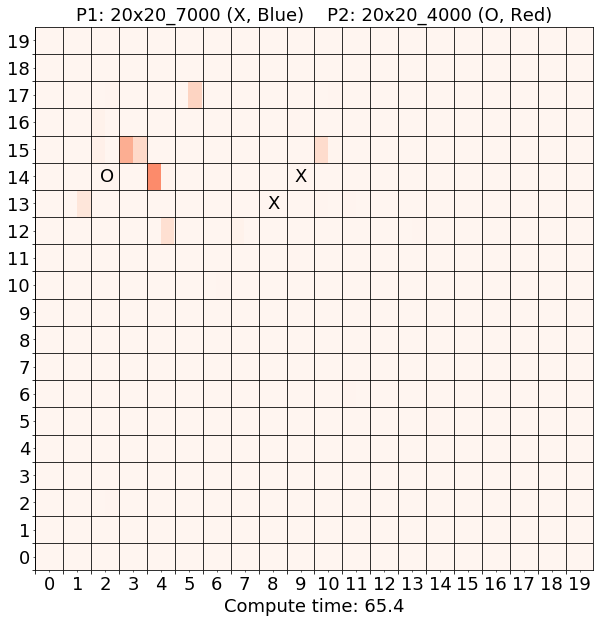

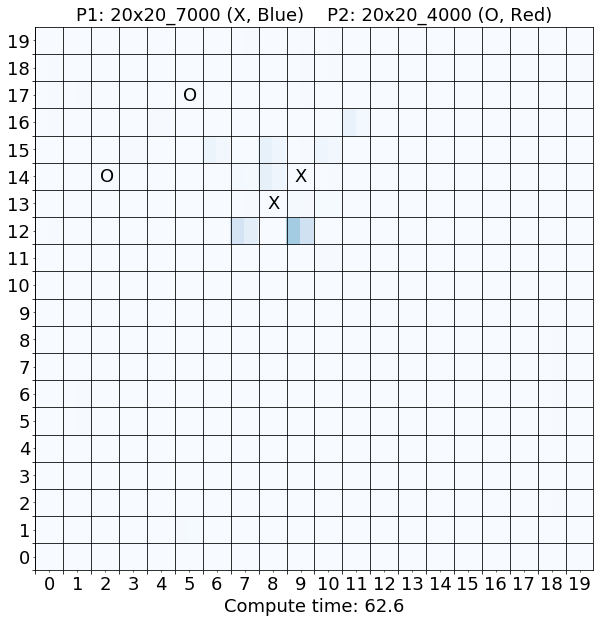

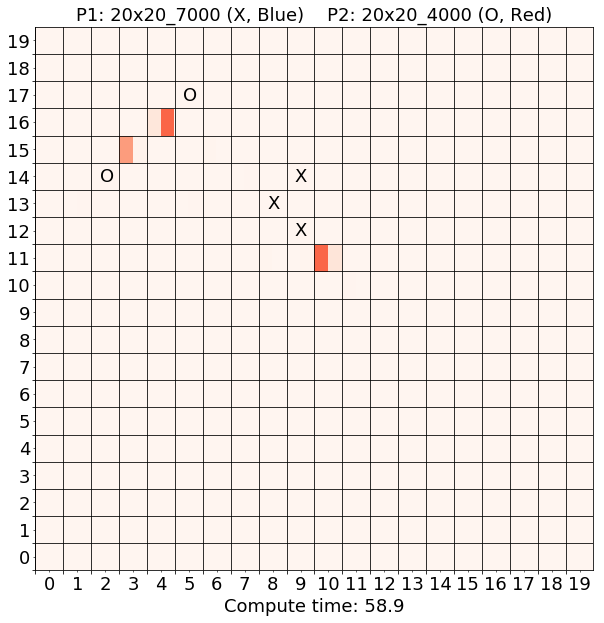

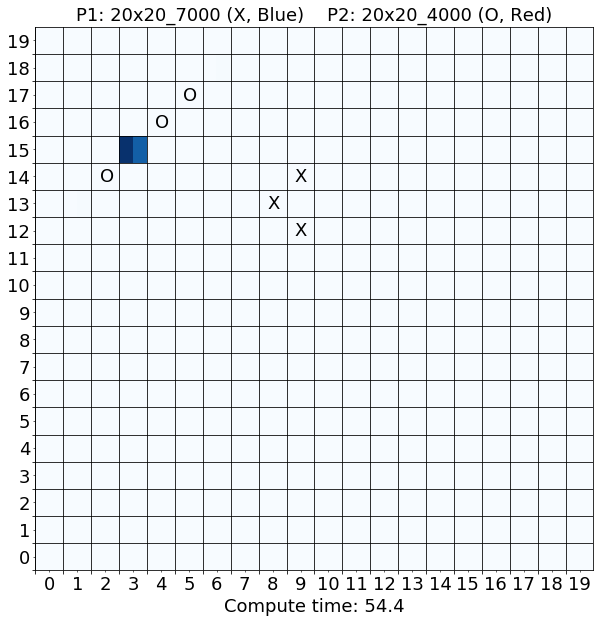

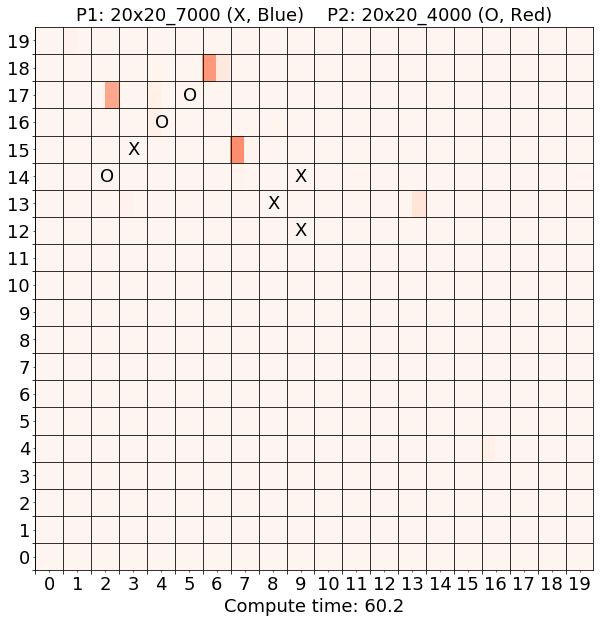

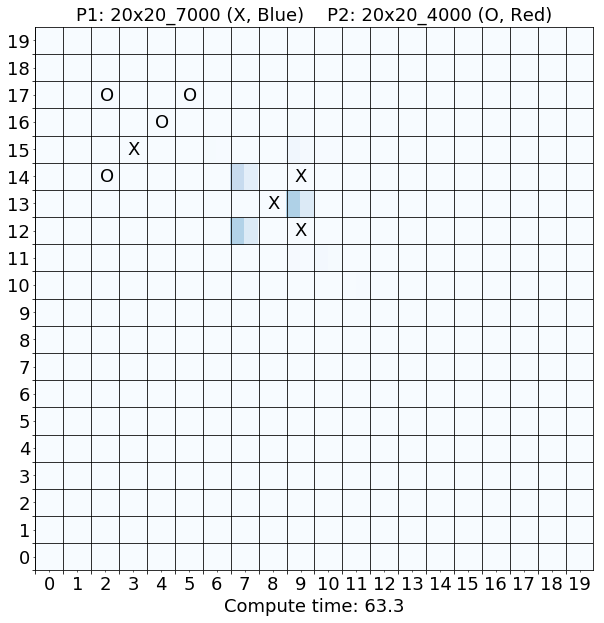

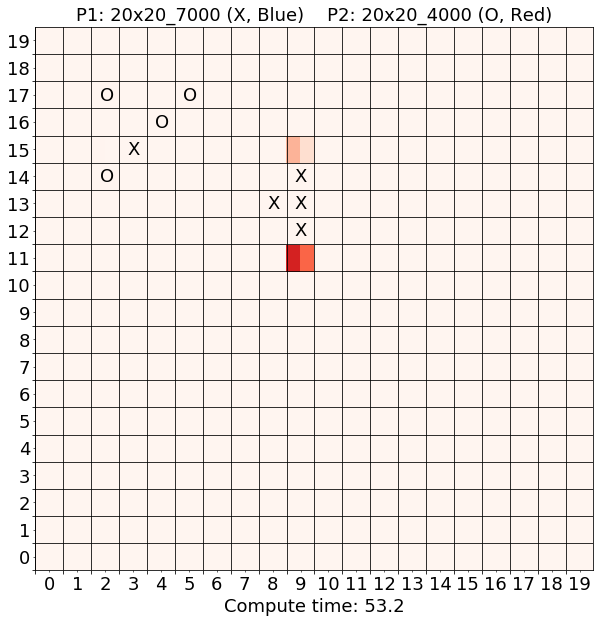

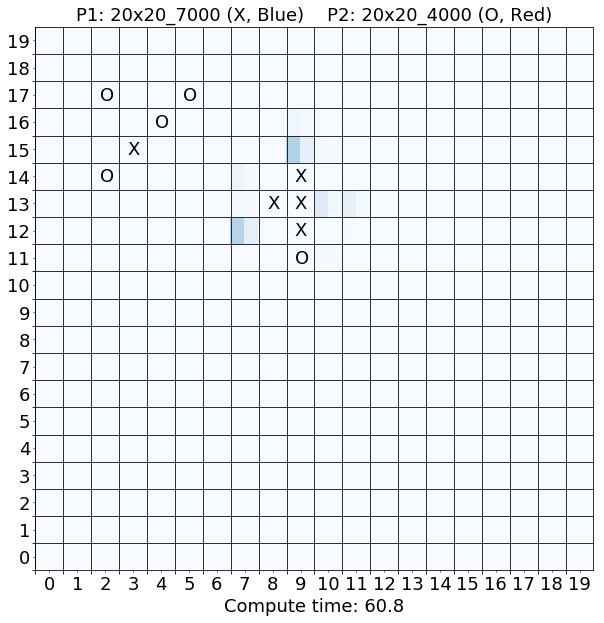

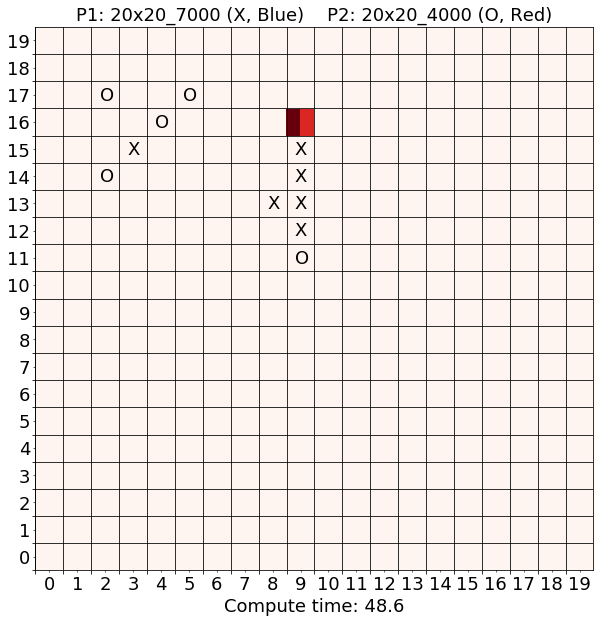

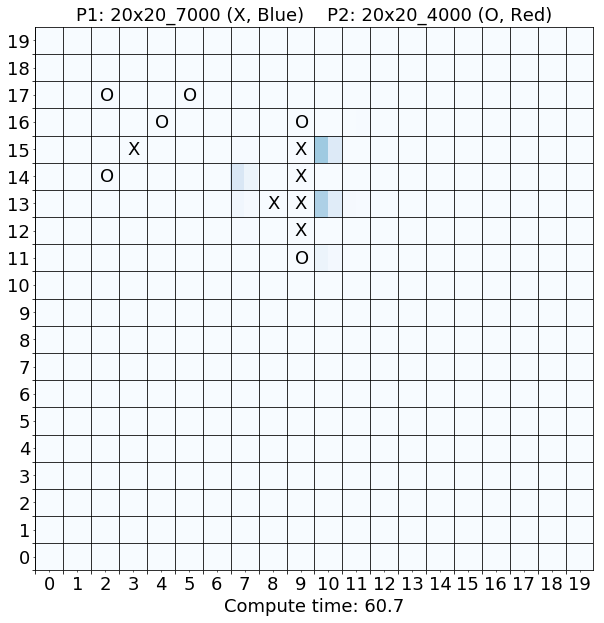

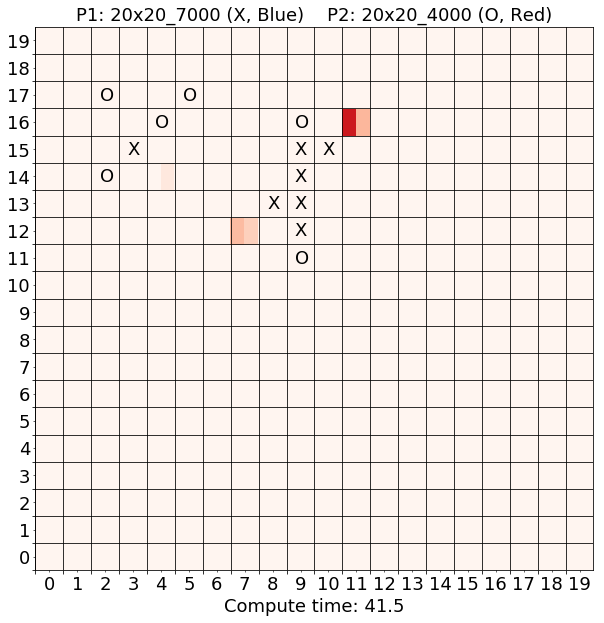

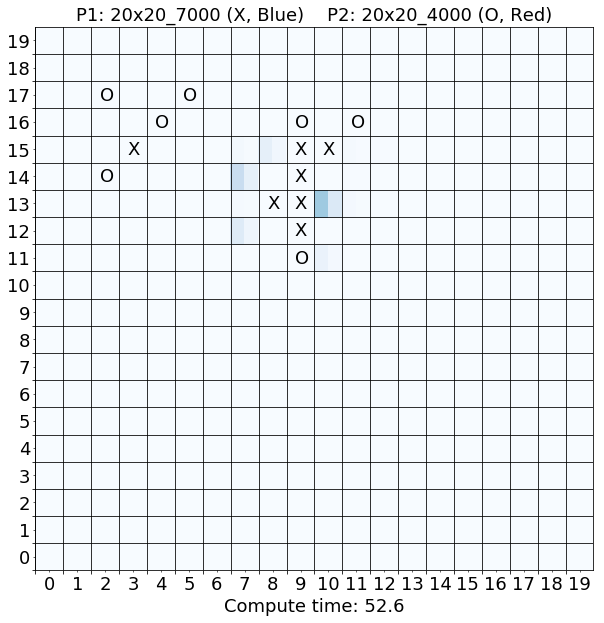

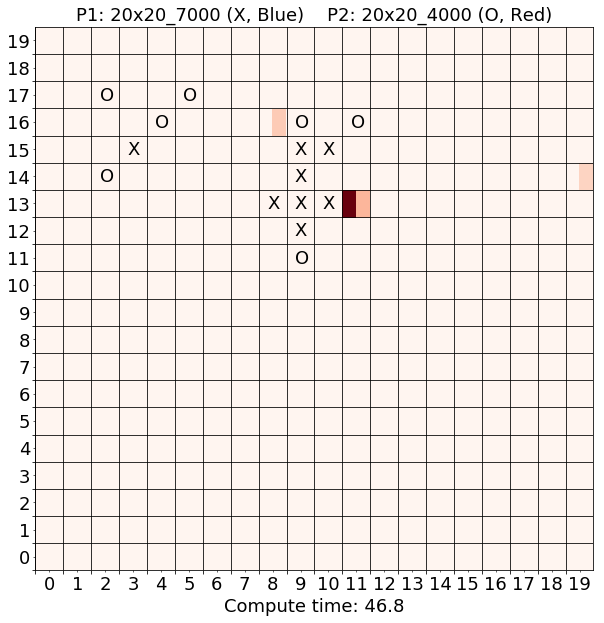

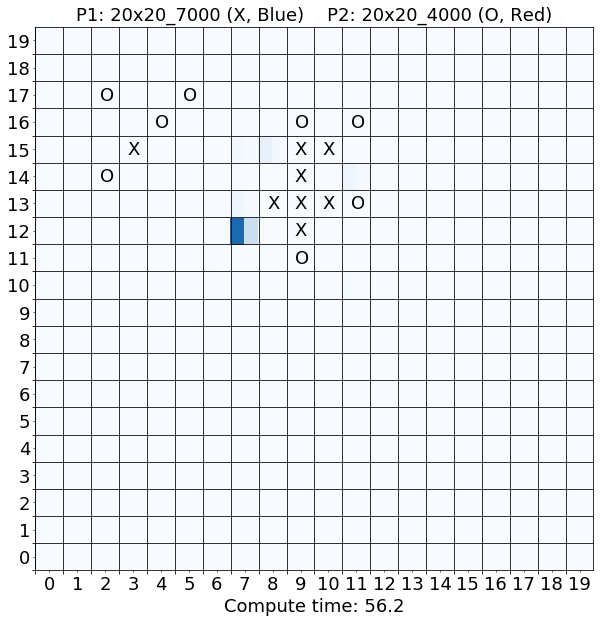

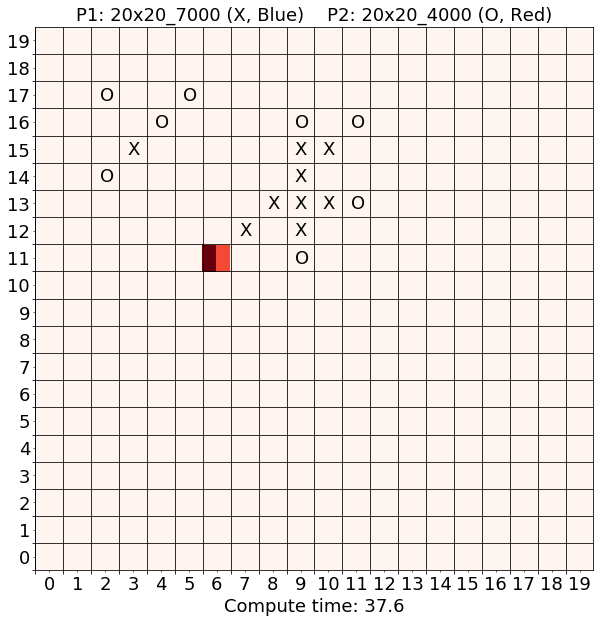

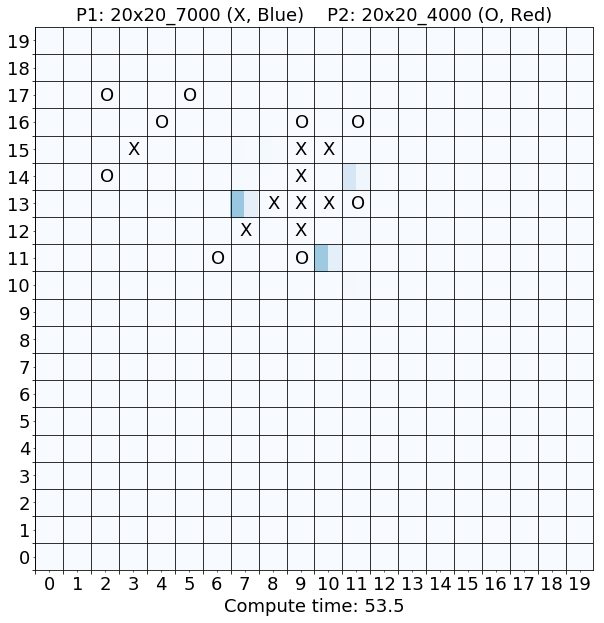

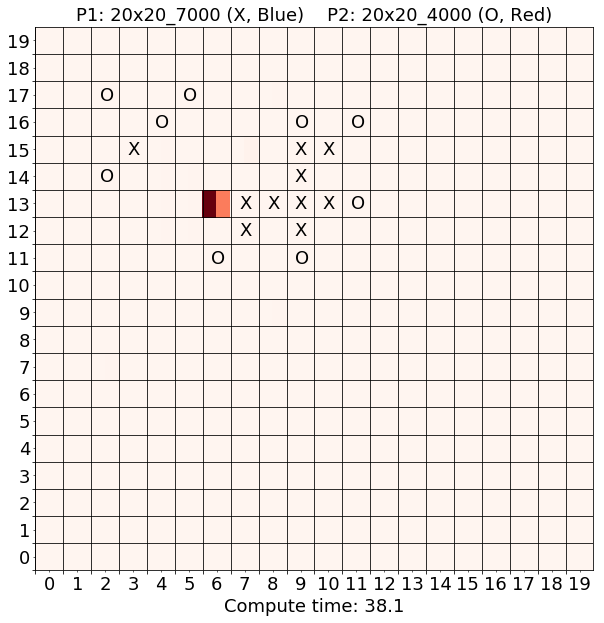

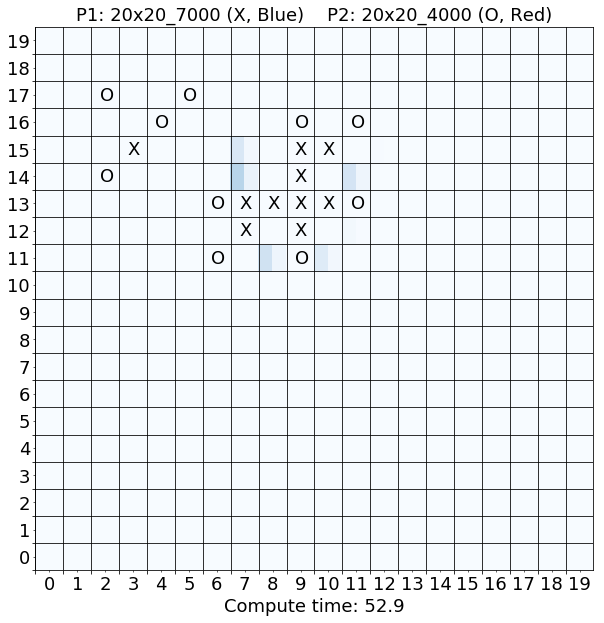

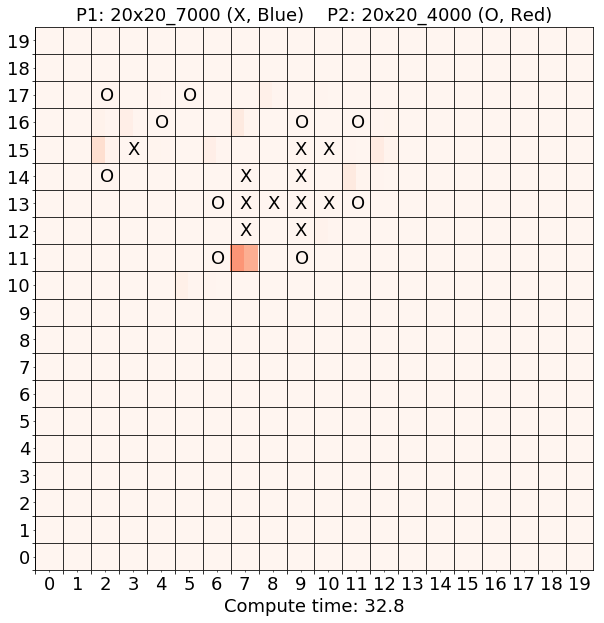

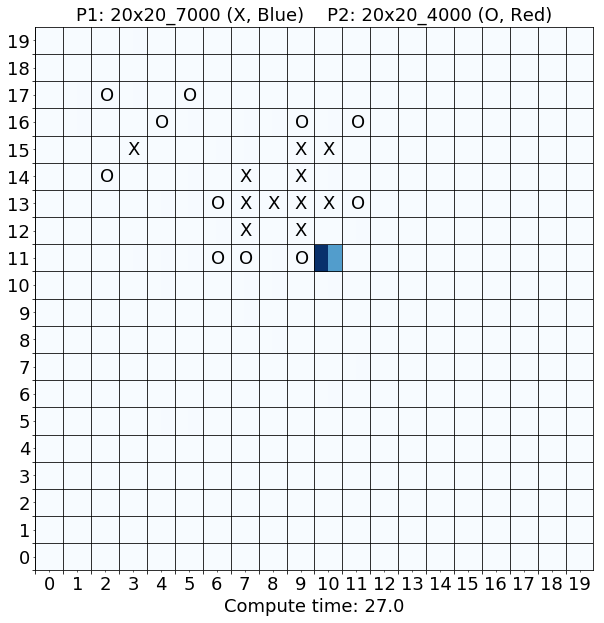

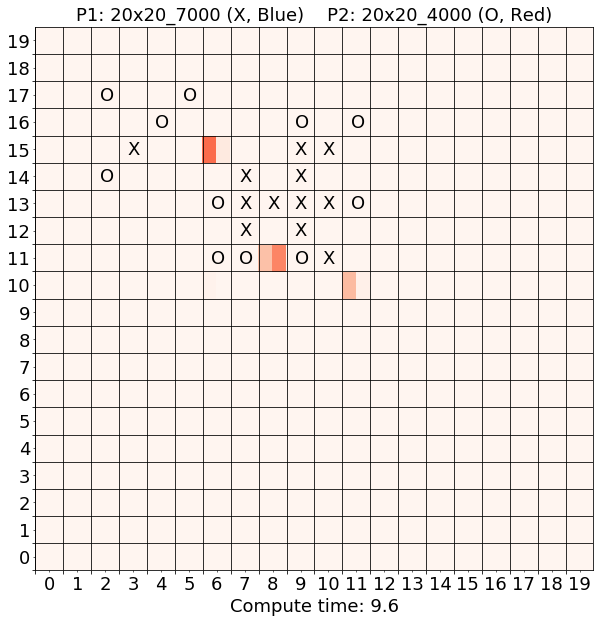

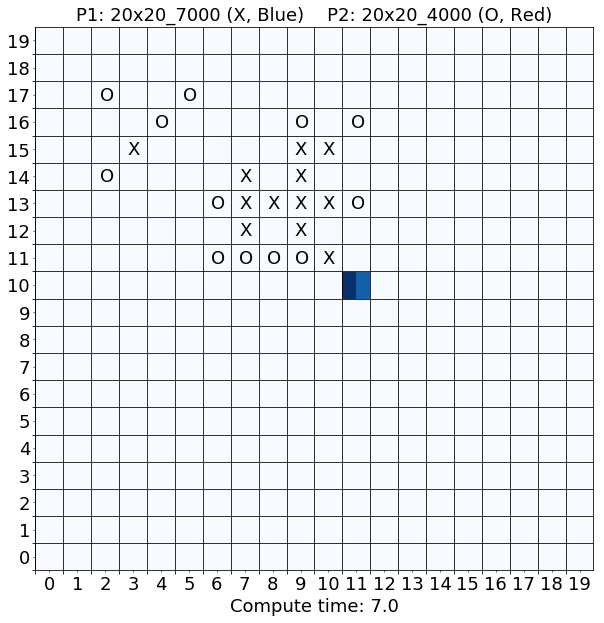

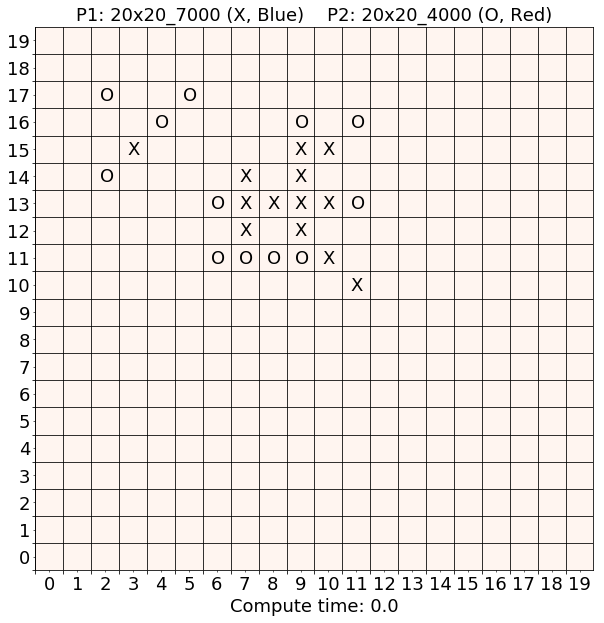

In [289]:
for t, info in enumerate(zip(*infos)):
    state, curr_p, curr_v, curr_W, curr_N, next_p, next_v, move, time = info
    plot_info(t, *info)
plot_info(t + 1, game['state'][-1])

make_video(sorted(output_dir.ls()[1]))